# Trabajo Práctico Especial: Selección de Distribuciones de Probabilidad

#### Modelos y Simulación - 2024

---


## Integrantes


- Juan Bratti
- Emanuel Nicolás Herrador


## Lectura de los datos


In [1]:
from matplotlib import pyplot as plt
from math import *
import scipy.stats as st
import seaborn as sns
import pandas as pd
import numpy as np
import random as rnd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Para reproducibilidad
np.random.seed(0)

In [2]:
# Leemos el documento
file_url = 'https://raw.githubusercontent.com/lbiedma/mysfamaf2024/main/trabajos_finales/sample24.dat'
df = pd.read_csv(file_url, header=None, names=['x'])

# Para chequear
df.head()

,x
0,2.213701
1,2.871230
2,4.031105
3,4.288337
4,0.202051


## Actividad 1


### Consigna

Elaboración de la hipótesis sobre la familia de distribuciones a la que pertenece la muestra. A tal fin realizar:

<ol type='a'>
    <li>Las estimaciones muestrales de: Valores máximos y mínimos, media, varianza y “skewness” (medida de la asimetría de la distribución).</li>
    <li>La confección de un histograma con los datos muestrales.</li>
    <li>El estudio de cuantiles en la muestra y confeccionar el correspondiente “box plot”.</li>
</ol>


### Item A


Los estimadores solicitados para nuestra muestra son los siguientes:


In [3]:
def sample_mean(data):
    return sum(data) / len(data)


def sample_variance(data):
    mean = sample_mean(data)
    return sum([(x - mean) ** 2 for x in data]) / (len(data) - 1)


def sample_skewness(data):
    mean = sample_mean(data)
    var = sample_variance(data)
    return sum([(x - mean) ** 3 for x in data]) / (len(data) * var**(3/2))


estimators = pd.DataFrame({
    'Mínimo': [df['x'].min()],
    'Máximo': [df['x'].max()],
    'Promedio': [sample_mean(df['x'])],
    'Varianza': [sample_variance(df['x'])],
    'Asimetría': [sample_skewness(df['x'])]
})

# También se puede usar con las funciones de la librería
# print(
#     df['x'].min(),
#     df['x'].max(),
#     df['x'].mean(),
#     df['x'].std()**2,
#     df['x'].skew()
# )

estimators

,Mínimo,Máximo,Promedio,Varianza,Asimetría
0,0.111128,13.342856,3.017981,3.209765,1.391727


### Item B


Si graficamos el histograma, obtenemos lo siguiente:


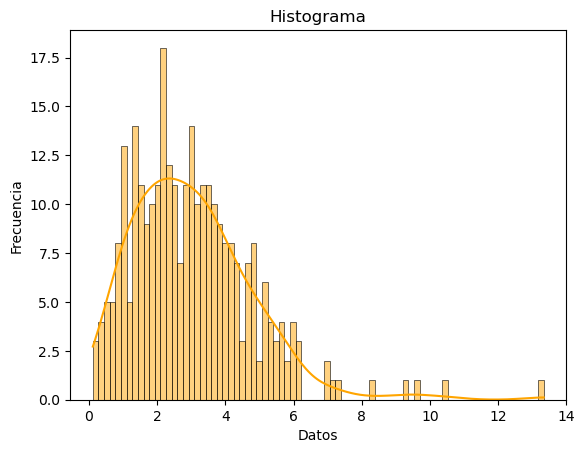

In [4]:
sns.histplot(data=df['x'], color='orange', kde=True, bins=80)

plt.title('Histograma')
plt.xlabel('Datos')
plt.ylabel('Frecuencia')

plt.show()

### Item C


Vamos a considerar el estudio de los cuantiles más importantes a la hora de realizar el gráfico de _Box-Plot_, los cuales corresponden entonces a los cuantiles $0.25$, $0.5$ y $0.75$.

A su vez, para ver si existen datos _outliers_, vamos a considerar también los cuantiles $0.05$ y $0.95$.

A continuación, se presentan los resultados obtenidos:


In [5]:
quantile_list = [0.05, 0.25, 0.5, 0.75, 0.95]

df['x'].quantile(quantile_list)

0.05    0.753190
0.25    1.729471
0.50    2.836248
0.75    4.030335
0.95    5.924371
Name: x, dtype: float64

Se puede notar que sí existen _outliers_, más que nada a la derecha de la distribución (lo cual puede verse fácilmente con el _histograma_ anterior), porque el máximo es $13.342856$ y el cuantil $0.95$ es $5.924371$.

Todo esto queda más claro cuando se realiza el gráfico de _Box-Plot_.


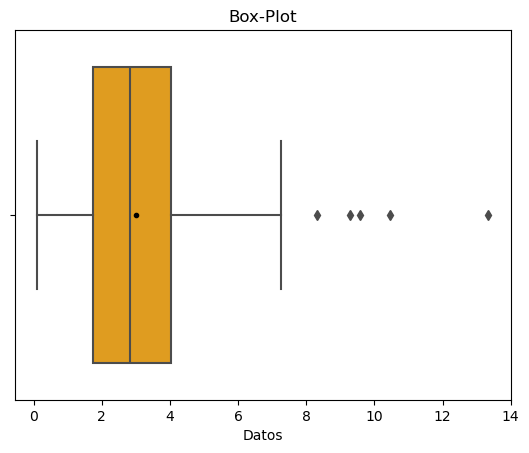

In [6]:
sns.boxplot(data=df, x='x', color='orange', fliersize=5, showmeans=True, meanprops={
            'marker': '.', 'markerfacecolor': 'black', 'markeredgecolor': 'black'})

plt.title('Box-Plot')
plt.xlabel('Datos')

plt.show()

## Actividad 2


### Consigna

Proposición de al menos dos familias de distribuciones de probabilidad como modelos de ajuste de los datos. Realizar la estimación de los parámetros de las correspondientes familias de distribuciones seleccionadas, utilizando el método de maxima verosimilitud.


### Resolución


Vamos a proponer como modelos de ajuste de los datos a las familias de las distribuciones _Normal_ y _Gamma_.

Por ello, vamos a considerar las funciones de generación de las correspondientes variables aleatorias continuas.
En el caso de la _Normal_ con todos los métodos vistos como Rechazo, Polar, Box-Muller, etc. Y en el caso de la _Gamma_, vamos a usar el método implementado en la librería de `scipy.stats`, dado que no se puede usar con el método de las Uniformes porque $\alpha$ no necesariamente es entero.


In [7]:
def normal_distribution(m, s, sz=1, method="rejection"):
    def rejection_method():
        while True:
            u, y = -np.log(rnd.random()), -np.log(rnd.random())
            if y >= (u - 1) ** 2 / 2:
                return (u if rnd.random() < 0.5 else -u)

    def polar_method():
        r2 = -2 * np.log(1 - rnd.random())
        theta = 2 * np.pi * rnd.random()
        x, y = np.sqrt(r2) * np.cos(theta), np.sqrt(r2) * np.sin(theta)
        return [x, y]

    def box_muller_method():
        while True:
            v1, v2 = 2 * rnd.random() - 1, 2 * rnd.random() - 1
            if v1 ** 2 + v2 ** 2 <= 1:
                s = v1 ** 2 + v2 ** 2
                x, y = v1 * np.sqrt(-2 * np.log(s) / s), v2 * \
                    np.sqrt(-2 * np.log(s) / s)
                return [x, y]

    def uniform_ratios_method():
        c = 4 * np.exp(-0.5) / np.sqrt(2.0)
        while True:
            u, y = rnd.random(), 1 - rnd.random()
            z = c * (u - 0.5) / y
            if z ** 2 / 4 <= -np.log(y):
                return z

    match method:
        case "polar":
            r = []
            while len(r) < sz:
                r += [m + x * s for x in polar_method()]
            return r[:sz]
        case "box-muller":
            r = []
            while len(r) < sz:
                r += [m + x * s for x in box_muller_method()]
            return r[:sz]
        case "uniform_ratios":
            return [m + uniform_ratios_method() * s for _ in range(sz)]
        case "rejection":
            return [m + rejection_method() * s for _ in range(sz)]
        case _:
            raise ValueError(
                "Invalid method. Please use 'rejection', 'polar', 'box-muller' or 'uniform_ratios'.")


def gamma_distribution(alpha, beta, sz=1):
    return st.gamma.rvs(alpha, scale=1/beta, size=sz)

Para ello, tenemos que realizar la estimación de sus parámetros para ver si tiene _sentido_ lo que estamos queriendo realizar. Por ello mismo, veamos cada caso:

- **Normal**: Tiene como parámetros la media $\mu$ y el desvío estándar $\sigma$. Para estimarlos, se usan los estimadores de máxima verosimilitud calculados en el _EJ1 - Item A_, es decir, el promedio y el desvío muestral ($\bar{X}$ y $S(X)$)
- **Gamma**: Tiene como parámetros a $\alpha$ y $\beta$. Para estimarlos, primero notemos que $E[X] = \frac{\alpha}{\beta}$ y que $Var[X] = \frac{\alpha}{\beta^2}$. Por lo tanto, podemos despejar obteniendo que $\beta = \frac{E[X]}{Var[X]}$ y $\alpha = E[X]*\beta$.
  Dado esto, entonces, usamos los estimadores de máxima verosimilitud calculados en el _EJ1 - Item A_, es decir, el promedio y el desvío muestral ($\bar{X}$ y $S(X)$) para estimar $\alpha$ y $\beta$, quedándonos $$\beta = \frac{\bar{X}}{S^2(X)} \quad \text{y} \quad \alpha = \bar{X} * \beta$$

Teniendo esto en cuenta, vamos a graficar ejemplos de las distribuciones _Normal_ y _Gamma_ con los parámetros estimados.


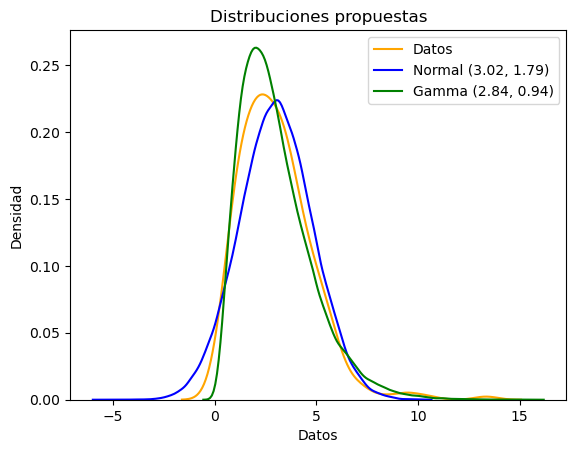

In [8]:
mean = sample_mean(df['x'])
var = sample_variance(df['x'])
std = np.sqrt(var)

# Datos
sns.kdeplot(data=df['x'], color='orange')

# Normal
normal_sample = normal_distribution(mean, std, 50_000)
sns.kdeplot(normal_sample, color='blue')

# Gamma
beta = mean / var
alpha = mean * beta
gamma_sample = gamma_distribution(alpha, beta, 50_000)
sns.kdeplot(gamma_sample, color='green')

plt.title('Distribuciones propuestas')
plt.xlabel('Datos')
plt.ylabel('Densidad')

plt.legend(['Datos', f'Normal ({mean:.2f}, {std:.2f})',
            f'Gamma ({alpha:.2f}, {beta:.2f})'])

plt.show()

## Actividad 3


### Consigna

Determinacion de la calidad de los ajustes logrados.

<ol type='a'>
    <li>Realizar una comparación de frecuencias entre el histograma de datos y cada una de las funciones de densidad f(x) propuestas para el ajuste. A tal fin, superponer sobre cada barra del histograma de datos una barra con altura igual a ∆bf(x), donde ∆b corresponde al ancho de intervalo en el histograma y f(x) es cada una de las densidades propuestas.</li>
    <li>Estimar el p-valor de la prueba de la hipótesis de que los datos provienen las distribuciones sugeridas, utilizando la aproximación ji-cuadrada.</li>
    <li>Estimar el p-valor de la prueba de la hipótesis de que los datos provienen la distribuciones sugeridas, en base al estadístico de Kolmogorov-Smirnov.</li>
    <li>Seleccionar finalmente una de las densidades de probabilidad propuestas y argumentar los motivos de dicha elección.</li>

</ol>


### Funciones de densidad acumuladas


Para este punto se tiene en cuenta que
$$\int_{-\infty}^x N(0,1)(t)dt$$
se calcula con `math.erf(x / math.sqrt(2.))/2 + 0.5` tal y como lo vimos en el práctico.

Y para la densidad acumulada de la _Gamma_, tenemos que se puede calcular con _Monte Carlo_. Notemos que la función de densidad de la _Gamma_ es
$$f(x) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} x^{\alpha-1} e^{-\beta x}$$

Luego, la función de densidad acumulada está dada por:

$$
\begin{aligned}
F(x) &= \int_{0}^{x} f(t) dt \\
&= \int_{0}^{x} \frac{\beta^{\alpha}}{\Gamma(\alpha)} t^{\alpha-1} e^{-\beta t} dt \\
&= \frac{\beta^{\alpha}}{\Gamma(\alpha)} \int_{0}^{x} t^{\alpha-1} e^{-\beta t} dt
\end{aligned}
$$

Ahora, también sabemos que para números reales, se cumple que

$$\Gamma(x) = \int_{0}^{\infty} t^{x-1} e^{-t} dt$$

Por ello, podemos calcular las integrales con _Monte Carlo_.


In [9]:
# NORMAL

def normal_cumulative_z(x):
    return erf(x / sqrt(2)) / 2 + 0.5



def normal_cumulative(x, mean, std):
    return normal_cumulative_z((x - mean) / std)

# GAMMA


def monteCarlo(f, a, b, n):
    """
    b es inf. si b es None
    """
    def estimate(f, a, b, n):
        r = 0
        for i in range(n):
            x = rnd.random()
            r += f(a + (b - a) * x)
        return (b - a) * r / n

    def g(x): return f(1/x - 1) / x**2
    match b:
        case None: return estimate(g, 0, 1, n) + estimate(f, a, 0, n)
        case _: return estimate(f, a, b, n)


class gamma:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.gamma_alpha = monteCarlo(
            lambda x: x**(alpha - 1) * np.exp(-x), 0, None, 10_000)

    def cdf(self, x):
        def f(t): return t**(self.alpha - 1) * np.exp(-t * self.beta)
        return self.beta**self.alpha / self.gamma_alpha * monteCarlo(f, 0, x, 10_000)

Sin embargo, al ser lento en los posteriores cálculos que vamos a realizar, preferimos hacer uso de la implementación existente en la librería de `scipy.stats`.


### Item A


Si superponemos las barras de los histogramas con las funciones de densidad, obtenemos lo siguiente:


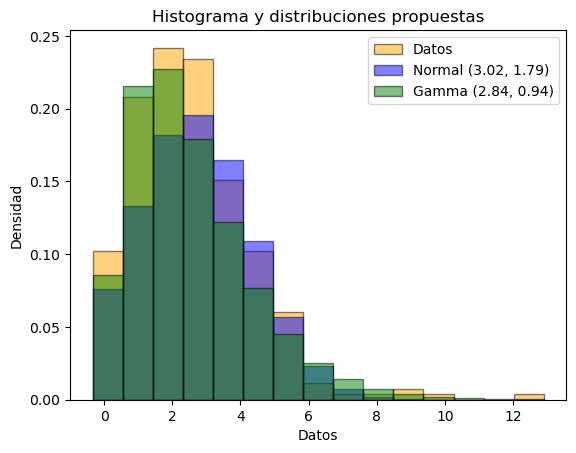

In [10]:
hist, bins = np.histogram(df['x'], bins=15, density=True)
diff = np.diff(bins)

# Calcular para la normal
normal_hist = [st.norm.pdf((bins[i] + bins[i + 1]) / 2,
                           mean, std) * diff[i] for i in range(len(bins) - 1)]

# Calcular para la gamma
gamma_hist = [st.gamma.pdf((bins[i] + bins[i + 1]) / 2, alpha, scale=1/beta) *
              diff[i] for i in range(len(bins) - 1)]

# Graficamos los tres histogramas
plt.bar(bins[:-1], hist, width=diff, alpha=0.5,
        color='orange', edgecolor='black')
plt.bar(bins[:-1], normal_hist, width=diff, alpha=0.5,
        color='blue', edgecolor='black')
plt.bar(bins[:-1], gamma_hist, width=diff, alpha=0.5,
        color='green', edgecolor='black')
# plt.plot(bins[:-1], normal_hist, color='blue')
# plt.plot(bins[:-1], gamma_hist, color='green')

plt.title('Histograma y distribuciones propuestas')
plt.xlabel('Datos')
plt.ylabel('Densidad')

plt.legend(['Datos', f'Normal ({mean:.2f}, {std:.2f})',
            f'Gamma ({alpha:.2f}, {beta:.2f})'])

plt.show()

Pero, para verlo mejor, podemos graficar las distribuciones propuestas como una curva continua.


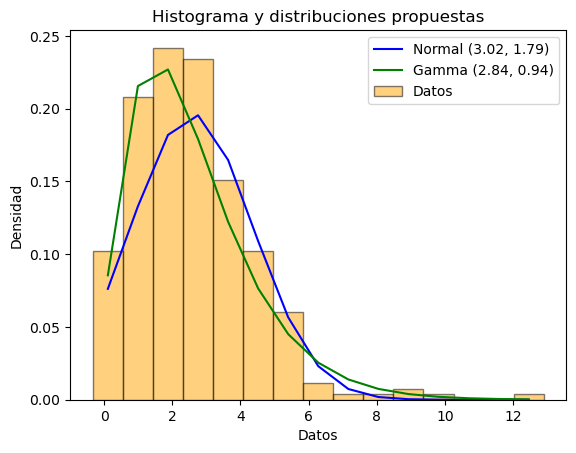

In [11]:
plt.bar(bins[:-1], hist, width=diff, alpha=0.5,
        color='orange', edgecolor='black')
plt.plot(bins[:-1], normal_hist, color='blue')
plt.plot(bins[:-1], gamma_hist, color='green')

plt.title('Histograma y distribuciones propuestas')
plt.xlabel('Datos')
plt.ylabel('Densidad')

plt.legend([f'Normal ({mean:.2f}, {std:.2f})',
           f'Gamma ({alpha:.2f}, {beta:.2f})', 'Datos'])

plt.show()

Luego, aquí se puede ver que la _Gamma_ es la que mejor se ajusta a los datos gráficamente.


### Item B


Para este punto, si bien los datos que tenemos son continuos, podemos usar el test de $\chi^2$ para ver si los datos provienen de una distribución _Normal_ o _Gamma_, haciendo una discretización de estos. Es decir, agrupando los datos en $k$ intervalos consecutivos y considerando $N_i$ como la cantidad observada en el $i$-ésimo intervalo, y $p_i$ como la probabilidad teórica (dada por la distribución que estamos considerando) de que "caiga" en el intervalo.


In [12]:
# Parámetros de división
K = 20
L, R = 0.1, 8

# Dividimos en intervalos (K + 1)
intervals = np.linspace(L, R, K)

# Contamos las observaciones
obs = np.zeros(K+1)
for x in df['x']:
    i = 0
    while i < K and x > intervals[i]:
        i += 1
    obs[i] += 1

Hecha esta división por intervalos, calculamos las probabilidades teóricas de las dos distribuciones propuestas:


In [13]:
def calculate_interval_prob(intervals, F):
    p = np.zeros(K+1)
    for i in range(len(intervals)):
        p[i] = F(intervals[i])
        if i > 0:
            p[i] -= F(intervals[i-1])
    p[K] = 1 - F(intervals[K-1])
    return p


# Calculamos las probabilidades
p_normal = calculate_interval_prob(
    intervals, lambda x: normal_cumulative(x, mean, std))
p_gamma = calculate_interval_prob(
    intervals, lambda x: st.gamma.cdf(x, a=alpha, scale=1/beta))

Ahora, con ello, podemos ya calcular el estadístico de $\chi^2$ y el p-valor asociado como vimos en clase.


In [14]:
def pearson_estimator(N, p):
    assert len(N) == len(p)

    n = sum(N)
    return sum((N[i] - n * p[i]) ** 2 / (n * p[i]) for i in range(len(N)))


def pearson_p_value(t, df):
    return 1.0 - st.chi2.cdf(t, df)


# NORMAL
normal_unspecified_params = 2
t_normal = pearson_estimator(obs, p_normal)
p_value_normal = pearson_p_value(t_normal, len(
    p_normal) - 1 - normal_unspecified_params)

# GAMMA
gamma_unspecified_params = 2
t_gamma = pearson_estimator(obs, p_gamma)
p_value_gamma = pearson_p_value(
    t_gamma, len(p_gamma) - 1 - gamma_unspecified_params)

# Mostramos los resultados
pearson = pd.DataFrame({
    'Distribución': ['Normal', 'Gamma'],
    'Estadístico': [t_normal, t_gamma],
    'Grados de libertad': [len(p_normal) - 1 - normal_unspecified_params, len(p_gamma) - 1 - gamma_unspecified_params],
    'P - Valor': [p_value_normal, p_value_gamma]
})

pearson

,Distribución,Estadístico,Grados de libertad,P - Valor
0,Normal,60.506644,18,0.000002
1,Gamma,16.023399,18,0.590914


Luego, si consideramos un nivel de confianza del $95\%$, entonces si el p-valor es menor a $0.05$, rechazamos la hipótesis nula de que los datos provienen de la distribución propuesta.

Ello nos dice, entonces que se rechaza la hipótesis nula de que los datos provienen de una distribución _Normal_, pero **no** se rechaza la hipótesis nula de que los datos provienen de una distribución _Gamma_.

Sin embargo, algo que tenemos que tener en cuenta es que el test de $\chi^2$ no es muy bueno para distribuciones continuas, dado que no tiene en cuenta la distribución de los datos en cada intervalo, sino que solo la cantidad de datos en cada uno. Por ello, vamos a realizar el test de Kolmogorov-Smirnov que nos va a brindar una mejor idea de si los datos provienen de una distribución _Normal_ o _Gamma_.


### Item C


Para este punto, vamos a considerar la prueba de Kolmogorov-Smirnov para ver si los datos provienen de una distribución _Normal_ o _Gamma_, dado que nuestros datos son _continuos_. Para ello, vamos a calcular el estadístico de Kolmogorov-Smirnov y el p-valor asociado (con simulación).


In [15]:
def kolmogorov_estimator(sample, F):
    n = len(sample)
    s_sample = sorted(sample)

    D = 0
    for i in range(n):
        D = max((i + 1) / n - F(s_sample[i]), F(s_sample[i]) - i / n, D)

    return D


N_SIM = 1_000

# NORMAL
D_normal = kolmogorov_estimator(
    df['x'], lambda x: normal_cumulative(x, mean, std))
p_value_normal = 0
for _ in range(N_SIM):
    sample = normal_distribution(mean, std, len(df))
    mean_sim, s_sim = sample_mean(sample), np.sqrt(sample_variance(sample))
    D_sim = kolmogorov_estimator(
        sample, lambda x: normal_cumulative(x, mean_sim, s_sim))
    if D_sim >= D_normal:
        p_value_normal += 1
p_value_normal /= N_SIM

# GAMMA
D_gamma = kolmogorov_estimator(
    df['x'], lambda x: st.gamma.cdf(x, a=alpha, scale=1/beta))
p_value_gamma = 0
for _ in range(N_SIM):
    sample = gamma_distribution(alpha, beta, len(df))
    mean_sim, var_sim = sample_mean(sample), sample_variance(sample)
    beta_sim = mean_sim / var_sim
    alpha_sim = mean_sim * beta_sim
    D_sim = kolmogorov_estimator(
        sample, lambda x: st.gamma.cdf(x, a=alpha_sim, scale=1/beta_sim))
    if D_sim >= D_gamma:
        p_value_gamma += 1
p_value_gamma /= N_SIM

# Mostramos los resultados
kolmogorov = pd.DataFrame({
    'Distribución': ['Normal', 'Gamma'],
    'Estadístico': [D_normal, D_gamma],
    'P - Valor': [p_value_normal, p_value_gamma]
})

kolmogorov

,Distribución,Estadístico,P - Valor
0,Normal,0.065913,0.006
1,Gamma,0.044331,0.175


Luego, entonces, con un nivel de confianza del $95\%$, volvemos a rechazar que los datos provienen de una distribución _Normal_, pero **no** rechazamos que los datos provienen de una distribución _Gamma_.


### Item D


La densidad de probabilidad que seleccionamos es la _Gamma_, dado que es la que mejor se ajusta a los datos que tenemos, ya que no se rechaza la hipótesis nula de que los datos provienen de una distribución _Gamma_.

Si bien en el gráfico de densidad de nuestros datos con muestras de las distribuciones _Normal_ y _Gamma_ parece que la _Normal_ se ajusta mejor, esto no es así, ya que algo a considerar es que nuestros datos **no presentan** valores negativos. Ahora, ¿esto es _tan_ relevante? Sí, y para ello vamos a calcular la probabilidad de que se obtenga una muestra de $300$ sin ningún valor negativo en el caso de una _Normal_:


In [16]:
prob = (1 - normal_cumulative(0, mean, std)) ** len(df['x'])
print(f'Probabilidad de NO obtener un valor menor a 0 en la muestra: {prob}')

Probabilidad de NO obtener un valor menor a 0 en la muestra: 7.230327509088463e-07


Luego, entonces, podemos ver que la probabilidad de que se obtenga una muestra de $300$ sin ningún valor negativo en el caso de una _Normal_ es muy baja, por lo que este hecho es _muy_ relevante y pesa mucho en la elección de la distribución _Gamma_.

Finalmente, entonces, por esta cuestión, por el hecho de que la _Gamma_ respeta no tener valores negativos y por los resultados obtenidos en los tests de hipótesis, elegimos la distribución _Gamma_ como la que mejor se ajusta a nuestros datos.


Sin embargo, una aclaración que queremos hacer es que todo este análisis considera que los datos muestrales _no están sesgados_ (respecto a ser solo positivos), sino que son una muestra uniforme de la distribución real.
